In [35]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
from pathlib import Path
import time
import math
from typing import Union
import os
import numpy as np
import torch
import cv2
from torch import Tensor
from tqdm import tqdm
import nvdiffrast.torch as dr
import matplotlib.pyplot as plt
import tree_segmentation as ts
from semantic_sam import semantic_sam_l
import torch_geometric as pyg
from tree_segmentation.extension import Mesh, ops_3d, utils
from tree_segmentation import Tree2D, Tree3Dv2, Tree3D, choose_best_views, random_camera_position
from paper.paper_util import get_2d_tree_from_3d
import open3d as o3d
import struct

/home/wan/Projects/Segmentation/TreeSeg


In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline
device = torch.device('cuda')
torch.set_grad_enabled(False)
glctx = dr.RasterizeCudaContext()

2.0.0+cu117


In [3]:
mesh_path = Path('~/data/meshes/winter_scene/low_poly_winter_scene.obj').expanduser().resolve()
print('mesh path:', mesh_path)
cache_dir = Path(f'./results/{ts.get_hash_name(mesh_path)}')
print('cache dir:', cache_dir)

mesh path: /home/wan/data/meshes/winter_scene/low_poly_winter_scene.obj
cache dir: results/f18abdf8888895cc312fc27a7f064ce7


In [4]:
cache_file = cache_dir.joinpath(mesh_path.name).with_suffix('.mesh_cache')
if cache_file.exists() and 1:
    mesh = torch.load(cache_file, map_location=device)  # type: Mesh
else:
    mesh = Mesh.load(mesh_path)
    mesh.float()
    mesh.int()
    mesh = mesh.unit_size()
    # mesh_ = mesh.to_open3d()
    # print(mesh_)
    # mesh_smp = mesh_.simplify_quadric_decimation(target_number_of_triangles=500_000, maximum_error=0.1)
    # mesh_smp = mesh_.simplify_vertex_clustering(target_number_of_triangles=500_000, maximum_error=0.5)
    # o3d.io.write_triangle_mesh(cache_dir.joinpath('simplified.ply').as_posix(), mesh_smp)
    # mesh = mesh.from_open3d(mesh_smp).cuda().unit_size()
    # print(mesh)
    mesh = mesh.cuda().unit_size()
    cache_dir.mkdir(exist_ok=True)
    torch.save(mesh, cache_file)
    print('save cached mesh to', cache_file)
mesh.compute_tangents_()
print(mesh)

Mesh(vertices=133234, faces=66051, tex, nrm, tng, mat=['name', 'ks', 'kd', 'ka', 'bsdf'])


# 2D Rendering and Segmentation

In [5]:
N = 100
fovy = math.radians(60)
image_size = 1024
if cache_dir.joinpath('Tw2v.pth').exists():
    Tw2vs = torch.load(cache_dir.joinpath('Tw2v.pth'), map_location=device)
else:
    ## 球面上的均匀格点
    # seq = torch.arange(N, device=device)
    # c = (math.sqrt(5) - 1) * math.pi
    # z = ((seq * 2 - 1) / N - 1).clamp(-1, 1)
    # x = torch.sqrt(1 - z * z) * (seq * c).cos()
    # y = torch.sqrt(1 - z * z) * (seq * c).sin()
    # eye = torch.stack([x, y, z], dim=-1) * 2.5
    # eye = eye * (torch.ones((N, 1), device=device))  # * (radius_range[1] - radius_range[0]) + radius_range[0])
    ## 随机采点
    N = N * 10
    phi_range = [0, math.pi * 2.]
    cos_theta_range = [math.cos(math.pi * 0.01), math.cos(math.pi * 0.5)]
    phis = torch.rand((N,), device=device) * (phi_range[1] - phi_range[0]) + phi_range[0]
    thetas = torch.arccos(
        torch.rand((N,), device=device) * (cos_theta_range[1] - cos_theta_range[0]) + cos_theta_range[0])
    radius = torch.full((N,), 1.8, device=device)
    eye = ops_3d.coord_spherical_to(radius, thetas, phis).to(device)
    Tw2vs = ops_3d.look_at(eye, torch.zeros_like(eye))
    print(utils.show_shape(Tw2vs))

    ## 最优选点
    # print(mesh.AABB)
    # random_camera_position(mesh, )
    N = N // 10
    Tv2c = ops_3d.perspective(fovy=fovy, size=(image_size, image_size), device=device)
    Tw2vs = Tw2vs[choose_best_views(glctx, mesh, Tv2c @ Tw2vs, N, image_size)]
    torch.save(Tw2vs, cache_dir.joinpath('Tw2v.pth'))
print(utils.show_shape(Tw2vs))


F32Tensor[100, 4, 4]


F32Tensor[100, 1024, 1024, 3], IntTensor[100, 1024, 1024]


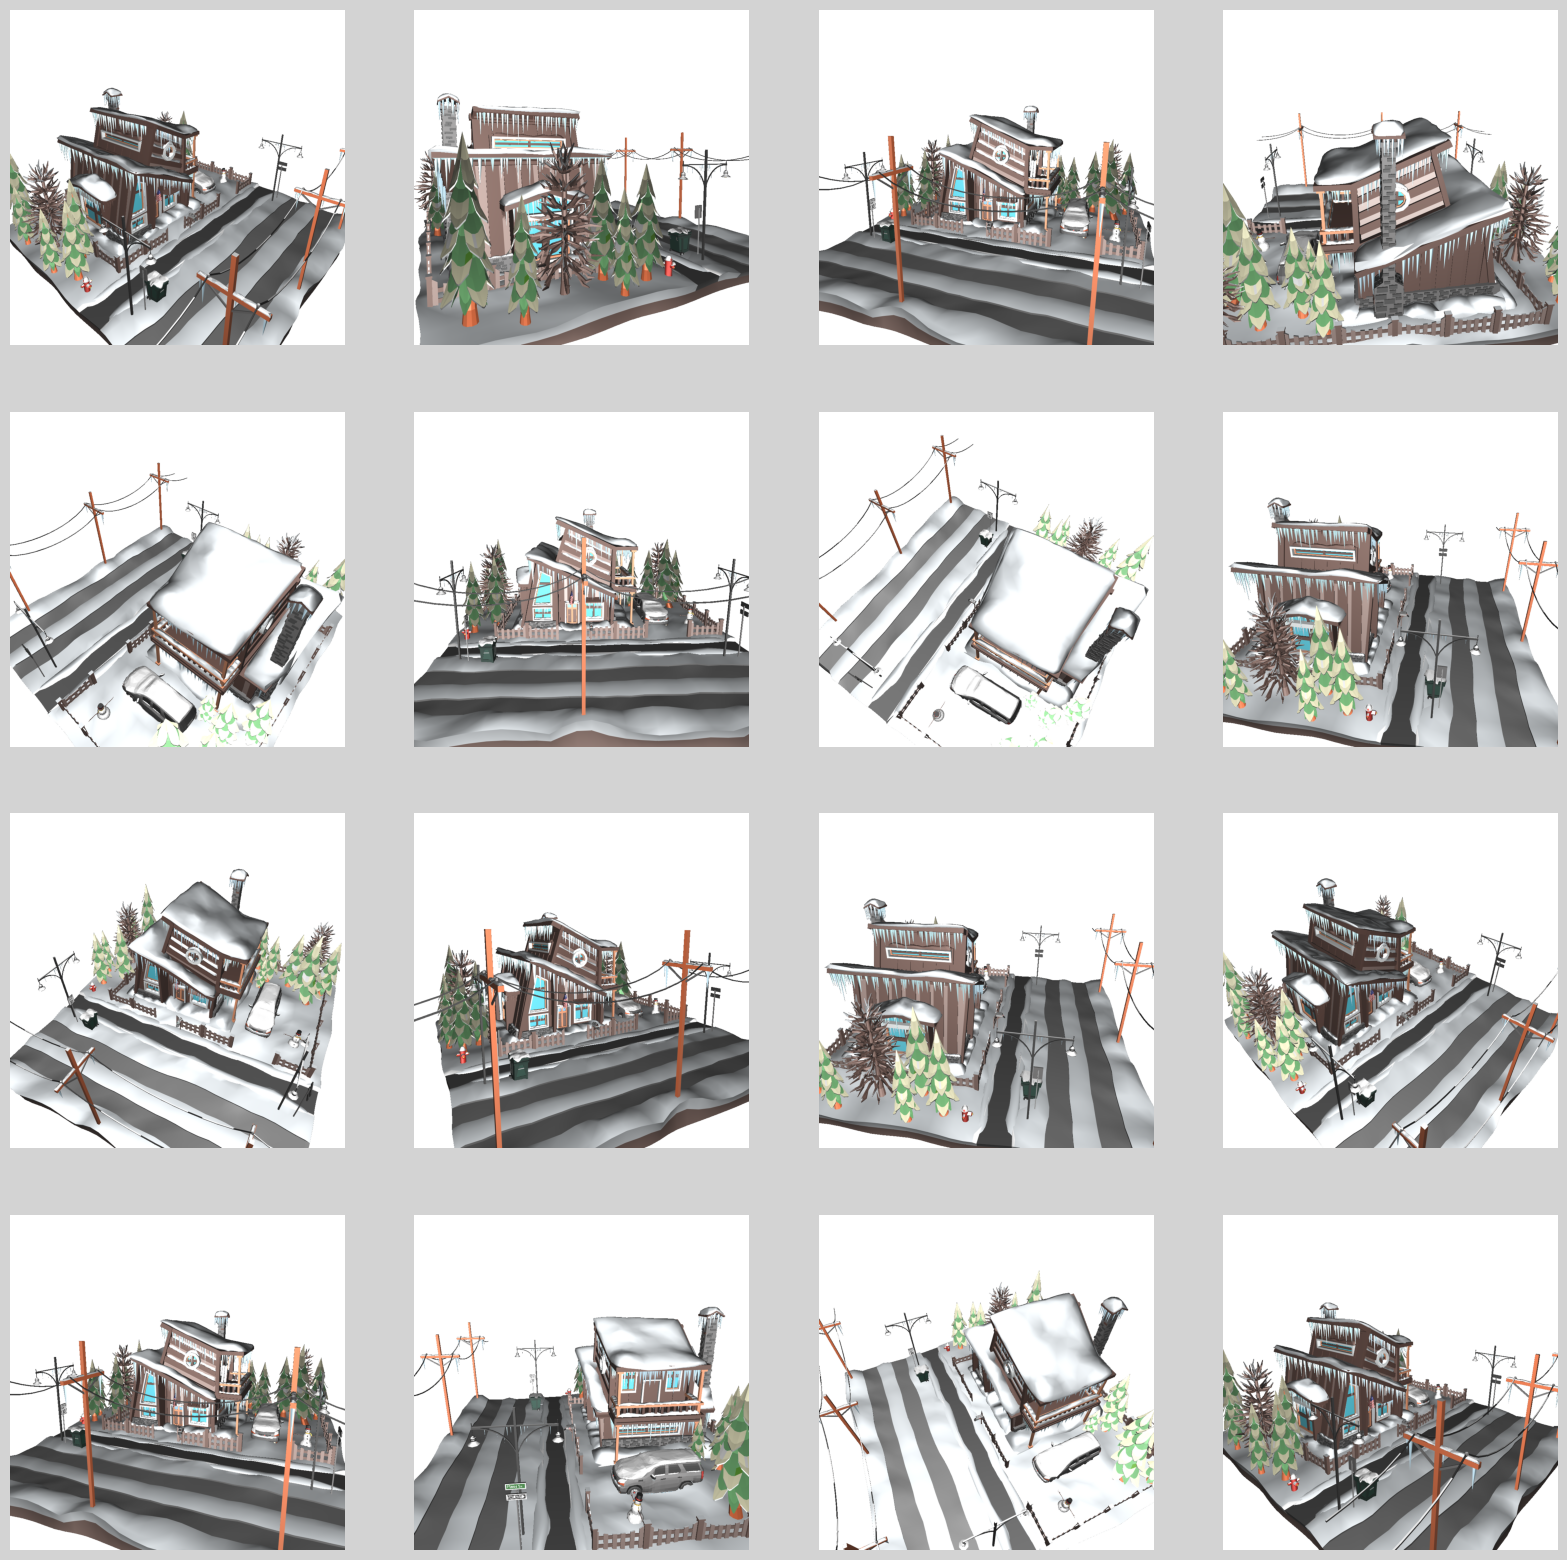

In [6]:
images, tri_ids = [], []
for i in range(0, N, 10):
    images_i, tri_ids_i = ts.render_mesh(
        glctx, mesh, Tw2v=Tw2vs[i:i + 10], image_size=image_size, fovy=fovy, background=1)
    images.append(images_i.cpu())
    tri_ids.append(tri_ids_i.cpu())
images, tri_ids = torch.cat(images), torch.cat(tri_ids)
print(utils.show_shape(images, tri_ids))
plt.figure(figsize=(20, 20), facecolor='lightgray')
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    # plt.imshow(images[i].cpu().numpy())
    plt.imshow(images[np.random.randint(0, N)].cpu().numpy())
    plt.axis('off')

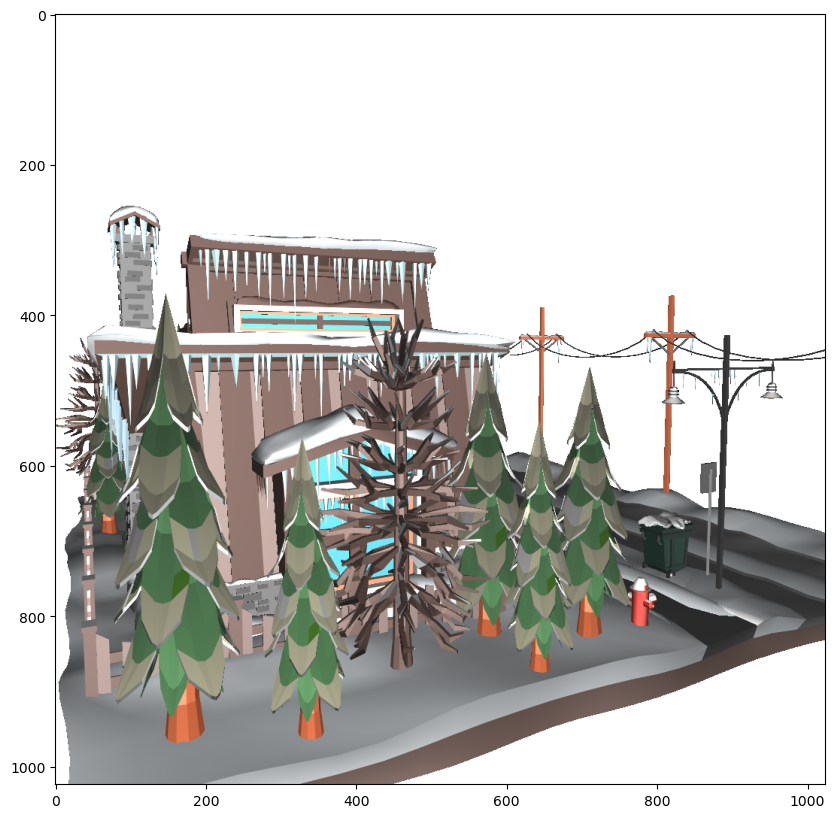

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0].cpu().numpy())

# 2D Segmentation

In [10]:
print(utils.get_GPU_memory())
ckpt_path = Path("~/models/segmentation/Semantic-SAM/swinl_only_sam_many2many.pth").expanduser()
model = semantic_sam_l(ckpt_path).eval().to(device)
predictor = ts.TreePredictor(model, stability_score_thresh=0.92, points_per_batch=256)
print(utils.get_GPU_memory())

(2.190514087677002, 31.7391357421875)
(1.0123844146728516, 31.7391357421875)


image: F32Tensor[1024, 1024, 3]
(11.36453104019165, 31.7391357421875)
(1.215517520904541, 31.7391357421875)


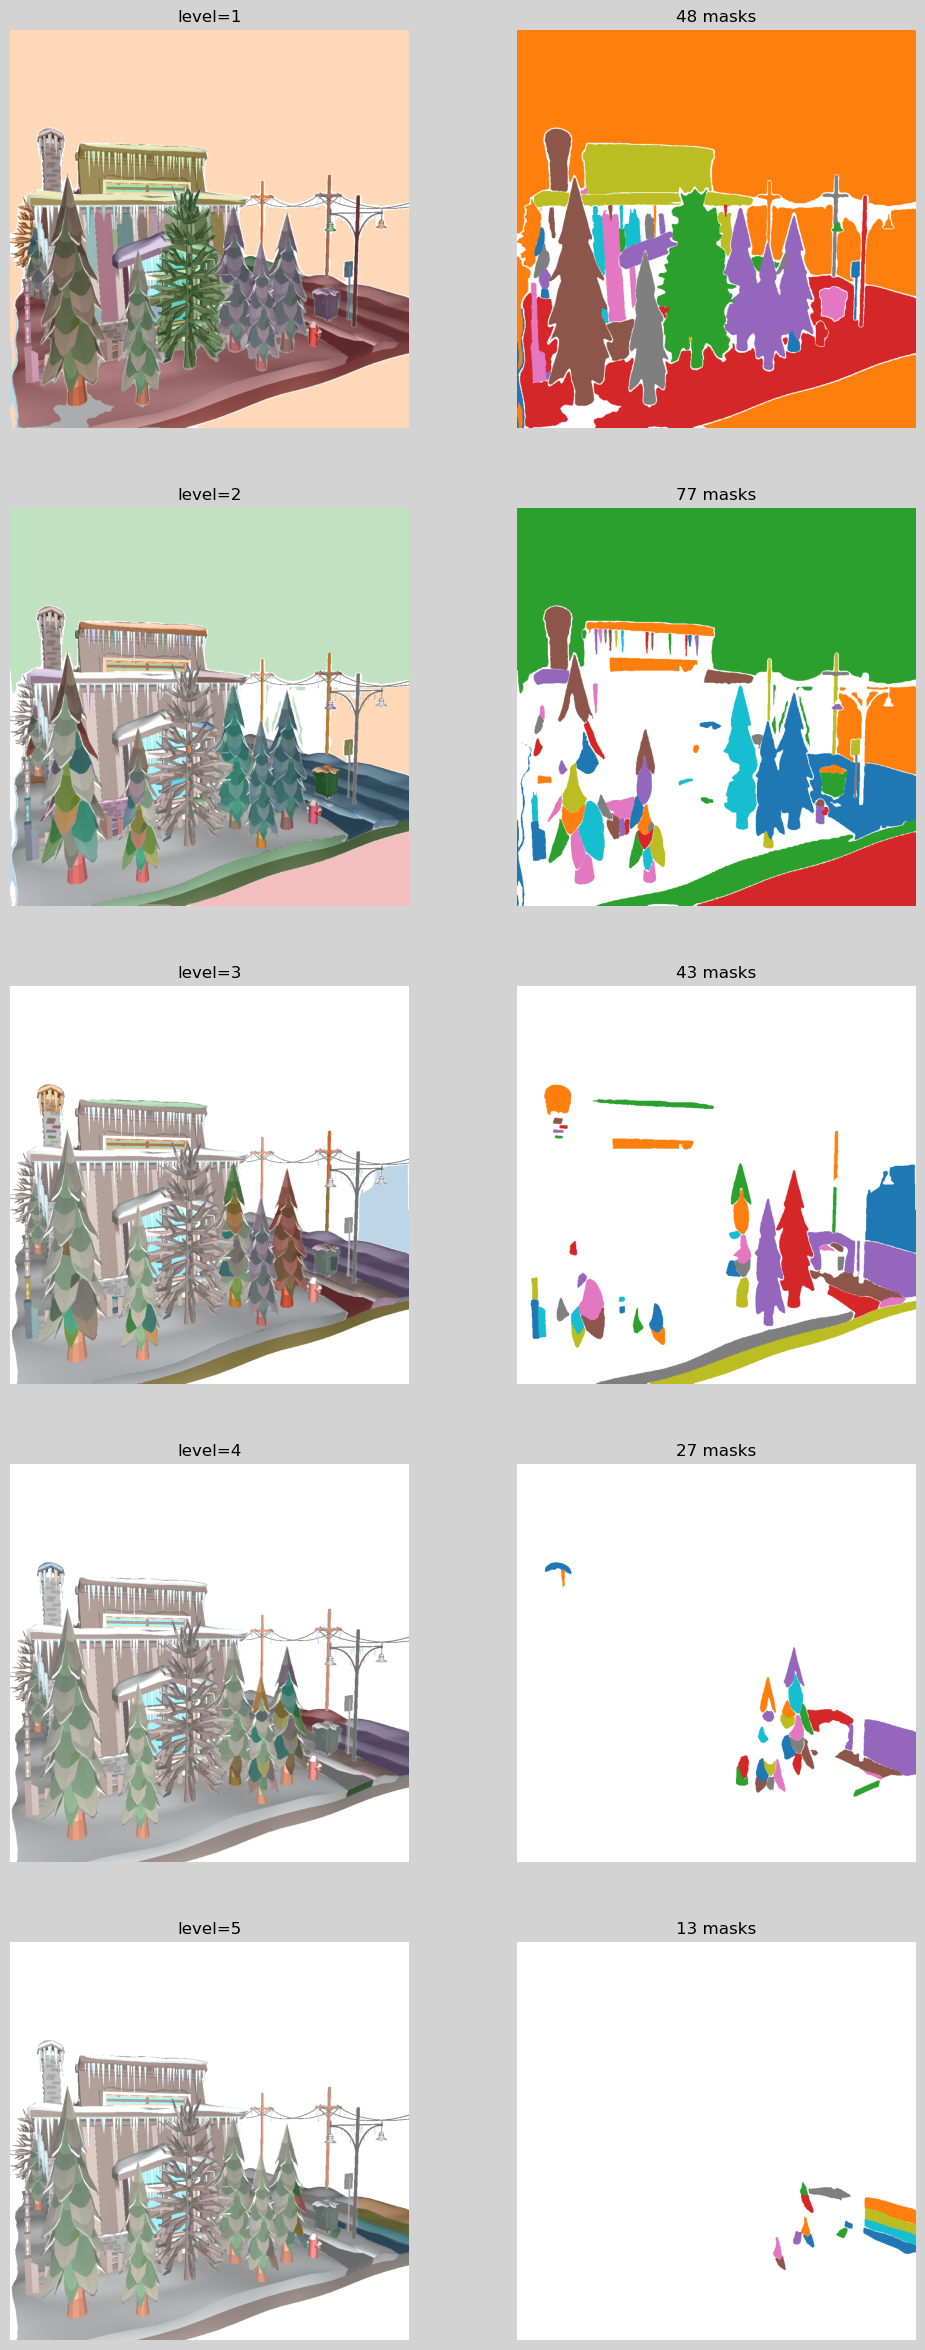

In [11]:
show_index = 0
image = images[show_index, :, :, :3]
print('image:', utils.show_shape(image))
tree_data = predictor.tree_generate(
    (image.cpu().numpy() * 255).astype(np.uint8),
    max_steps=100,
    in_threshold=0.8,
    union_threshold=0.1,
    min_mask_region_area=100,
    points_per_update=256,
    device=device,
    in_thre_area=50,
)
ts.show_all_levels(image, tree_data, facecolor='lightgray', width=6)
print(utils.get_GPU_memory())
del tree_data
torch.cuda.empty_cache()
print(utils.get_GPU_memory())

In [12]:
# from rich.progress import track
from IPython.display import clear_output

for index in tqdm(range(N)):
    if 1 and cache_dir.joinpath(f"view_{index:04d}.data").exists():
        continue
    tree_data = predictor.tree_generate(
        (images[index, :, :, :3].cpu().numpy() * 255).astype(np.uint8),
        max_steps=100,
        in_threshold=0.8,
        union_threshold=0.1,
        min_mask_region_area=100,
        points_per_update=256,
        device=device,
        in_thre_area=50,
    )
    data = {
        'tree_data': tree_data.save(filename=None),
        'tri_id': tri_ids[index].clone(),
        'image': images[index].clone(),
        'Tw2v': Tw2vs[index].clone(),
    }
    torch.save(data, cache_dir.joinpath(f"view_{index:04d}.data"))

    clear_output(wait=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 45949.87it/s]


# 3D Segmentation

In [8]:
tree3d = Tree3Dv2(mesh, device=device, verbose=1)
# tree3d.load(cache_dir.joinpath('my.tree3dv2'))
tree3d.load_2d_results(cache_dir, pack=True)
print(tree3d.masks_2d.shape)

[Tree] reset
[Tree3D] GPU: (2.190514087677002, 31.7391357421875)
[Tree3D] There are 100 data
[Tree3D] {'tree_data': {'parent': IntTensor[218], 'first': IntTensor[218], 'next': IntTensor[218], 'last': IntTensor[218], 'cnt': 217, 'num_samples': IntTensor[218], 'masks': IntTensor[5, 1024, 1024], 'scores': F16Tensor[217], 'extra': {}}, 'tri_id': IntTensor[1024, 1024], 'image': F32Tensor[1024, 1024, 3], 'Tw2v': F32Tensor[4, 4]}
[Tree3D] GPU: (0.17502355575561523, 31.7391357421875)
[Tree3D] view_masks, view_infos[0]: BoolTensor[100, 66052], (IntTensor[8294], LongTensor[8294])
[Tree3D] loaded 100 views, 17090 masks, max_num: 272
[Tree3D] GPU: (3.605454444885254, 31.7391357421875)
torch.Size([600, 66052])


In [9]:
# Gv = tree3d.build_view_graph()
# Gm = tree3d.build_graph(Gv)
A = tree3d.build_all_graph()
X, autoencoder = tree3d.compress_masks(epochs=3000)
print(autoencoder)
print(utils.get_GPU_memory())

[Tree3D] start build view graph
[Tree3D] start build graph
[Tree3D] X epoch[   0], loss: recon= 0.710, lr=1.000e-03
[Tree3D] X epoch[ 100], loss: recon= 0.156, lr=9.972e-04
[Tree3D] X epoch[ 200], loss: recon= 0.018, lr=9.890e-04
[Tree3D] X epoch[ 300], loss: recon= 0.015, lr=9.754e-04
[Tree3D] X epoch[ 400], loss: recon= 0.014, lr=9.566e-04
[Tree3D] X epoch[ 500], loss: recon= 0.012, lr=9.328e-04
[Tree3D] X epoch[ 600], loss: recon= 0.011, lr=9.043e-04
[Tree3D] X epoch[ 700], loss: recon= 0.010, lr=8.714e-04
[Tree3D] X epoch[ 800], loss: recon= 0.009, lr=8.343e-04
[Tree3D] X epoch[ 900], loss: recon= 0.009, lr=7.937e-04
[Tree3D] X epoch[1000], loss: recon= 0.008, lr=7.498e-04
[Tree3D] X epoch[1100], loss: recon= 0.008, lr=7.032e-04
[Tree3D] X epoch[1200], loss: recon= 0.008, lr=6.544e-04
[Tree3D] X epoch[1300], loss: recon= 0.007, lr=6.038e-04
[Tree3D] X epoch[1400], loss: recon= 0.006, lr=5.522e-04
[Tree3D] X epoch[1500], loss: recon= 0.007, lr=5.000e-04
[Tree3D] X epoch[1600], loss:

In [11]:
K = tree3d.Lmax * 2
gnn = pyg.nn.GCN(in_channels=X.shape[1], hidden_channels=128, num_layers=2, out_channels=K, norm='BatchNorm').cuda()
print(gnn)
tree3d.run(epochs=10000, K=K, gnn=gnn, A=A * A.ge(0.5), X=X)

now_date = time.strftime("%m-%d_%H:%M:%S", time.localtime(time.time()))
tree3d.save(cache_dir.joinpath(f'my_{now_date}.tree3dv2'))

GCN(256, 544, num_layers=2)
[Tree3D] GPU: (19.27702236175537, 31.7391357421875)
[Tree3D] GPU: (19.026561737060547, 31.7391357421875)
[Tree3D] Epoch 100: loss=1.850470, recon= 0.002, match= 0.912, vm= 0.917, mv= 0.072, tree= 0.004
[Tree3D] Epoch 200: loss=1.625653, recon= 0.002, match= 0.780, vm= 0.805, mv= 0.106, tree= 0.003
[Tree3D] Epoch 300: loss=1.572992, recon= 0.002, match= 0.721, vm= 0.759, mv= 0.114, tree= 0.003
[Tree3D] Epoch 400: loss=1.499455, recon= 0.002, match= 0.704, vm= 0.739, mv= 0.121, tree= 0.004
[Tree3D] Epoch 500: loss=1.257427, recon= 0.002, match= 0.642, vm= 0.688, mv= 0.126, tree= 0.005
[Tree3D] Epoch 600: loss=1.144112, recon= 0.002, match= 0.628, vm= 0.673, mv= 0.125, tree= 0.005
[Tree3D] Epoch 700: loss=1.412291, recon= 0.002, match= 0.622, vm= 0.672, mv= 0.133, tree= 0.005
[Tree3D] Epoch 800: loss=1.360958, recon= 0.002, match= 0.595, vm= 0.648, mv= 0.135, tree= 0.005
[Tree3D] Epoch 900: loss=1.262735, recon= 0.002, match= 0.573, vm= 0.631, mv= 0.137, tree= 

0: Tree Root
├── 459
├── 453
├── 452
├── 450
├── 432
├── 431
├── 427
├── 426
├── 421
├── 420
├── 412
├── 409
├── 405
├── 397
├── 396
├── 391
├── 387
├── 385
├── 382
├── 379
├── 377
├── 372
├── 366
├── 361
├── 359
│   └── 368
├── 351
│   └── 132
├── 350
│   └── 203
├── 349
├── 344
├── 342
│   └── 458
├── 341
├── 340
├── 338
├── 333
├── 331
│   └── 417
│       └── 444
├── 327
├── 325
├── 323
├── 318
├── 315
├── 312
├── 308
├── 305
├── 281
├── 271
├── 268
├── 257
├── 254
├── 251
├── 248
├── 239
├── 226
├── 224
├── 223
├── 222
├── 219
├── 218
├── 215
├── 212
├── 206
├── 196
│   └── 313
├── 190
├── 187
├── 183
├── 180
├── 171
├── 166
├── 159
├── 155
├── 153
├── 152
├── 137
├── 135
│   └── 209
│       └── 292
├── 134
├── 133
├── 130
├── 124
├── 123
├── 118
│   └── 121
├── 110
├── 100
├── 97
├── 92
│   └── 461
├── 90
├── 87
├── 86
│   └── 69
├── 80
├── 78
│   ├── 462
│   ├── 457
│   ├── 447
│   ├── 440
│   ├── 437
│   ├── 435
│   ├── 434
│   ├── 429
│   │   └── 414
│   ├── 425
│   ├── 418
│   ├── 408
│   ├── 406
│   ├── 403
│   ├── 401
│   ├── 400
│   ├── 399
│   ├── 395
│   ├── 393
│   ├── 392
│   ├── 370
│   ├── 369
│   ├── 367
│   ├── 365
│   ├── 364
│   ├── 363
│   ├── 362
│   ├── 356
│   ├── 355
│   ├── 353
│   ├── 343
│   ├── 336
│   ├── 328
│   ├── 326
│   ├── 319
│   ├── 310
│   ├── 309
│   ├── 307
│   ├── 303
│   ├── 300
│   ├── 297
│   ├── 295
│   ├── 289
│   ├── 288
│   ├── 286
│   ├── 284
│   ├── 283
│   ├── 276
│   ├── 274
│   ├── 267
│   ├── 245
│   ├── 244
│   ├── 240
│   ├── 237
│   ├── 235
│   ├── 234
│   ├── 232
│   │   └── 378
│   ├── 230
│   ├── 229
│   ├── 221
│   ├── 210
│   ├── 207
│   ├── 205
│   ├── 202
│   ├── 198
│   ├── 197
│   ├── 195
│   ├── 193
│   ├── 188
│   ├── 179
│   ├── 170
│   ├── 164
│   │   └── 157
│   ├── 161
│   ├── 160
│   ├── 158
│   ├── 156
│   ├── 150
│   ├── 145
│   ├── 136
│   ├── 114
│   ├── 113
│   ├── 112
│   ├── 111
│   ├── 107
│   ├── 96
│   ├── 93
│   ├── 83
│   ├── 81
│   ├── 5
│   ├── 8
│   ├── 9
│   │   ├── 173
│   │   └── 125
│   ├── 13
│   ├── 14
│   │   ├── 109
│   │   └── 39
│   ├── 17
│   ├── 21
│   ├── 24
│   │   ├── 285
│   │   ├── 139
│   │   └── 40
│   │       ├── 147
│   │       ├── 58
│   │       │   └── 105
│   │       │       └── 233
│   │       │           └── 280
│   │       └── 32
│   │           ├── 446
│   │           ├── 311
│   │           ├── 117
│   │           ├── 95
│   │           │   └── 185
│   │           ├── 88
│   │           │   └── 287
│   │           │       └── 120
│   │           ├── 84
│   │           └── 4
│   │               └── 320
│   ├── 34
│   ├── 36
│   ├── 37
│   │   └── 352
│   │       └── 66
│   ├── 41
│   ├── 45
│   ├── 47
│   ├── 48
│   ├── 49
│   ├── 51
│   ├── 54
│   ├── 59
│   │   ├── 456
│   │   ├── 441
│   │   ├── 439
│   │   ├── 384
│   │   ├── 306
│   │   ├── 273
│   │   ├── 247
│   │   ├── 211
│   │   ├── 191
│   │   ├── 176
│   │   ├── 167
│   │   ├── 151
│   │   ├── 119
│   │   │   ├── 449
│   │   │   ├── 416
│   │   │   ├── 389
│   │   │   └── 1
│   │   ├── 108
│   │   │   └── 6
│   │   ├── 102
│   │   ├── 68
│   │   │   └── 165
│   │   ├── 7
│   │   │   ├── 278
│   │   │   ├── 227
│   │   │   └── 101
│   │   │       ├── 460
│   │   │       │   └── 301
│   │   │       ├── 277
│   │   │       ├── 148
│   │   │       └── 12
│   │   └── 30
│   │       └── 44
│   ├── 65
│   │   ├── 448
│   │   ├── 265
│   │   └── 85
│   ├── 76
│   └── 77
├── 71
├── 70
├── 53
│   ├── 143
│   ├── 82
│   ├── 60
│   └── 10
├── 50
├── 43
│   ├── 424
│   ├── 374
│   ├── 249
│   ├── 55
│   └── 26
│       └── 423
├── 42
├── 35
│   ├── 178
│   │   └── 430
│   └── 172
├── 31
├── 28
├── 27
│   └── 208
├── 23
│   ├── 75
│   └── 2
├── 22
├── 20
├── 19
│   ├── 186
│   │   ├── 322
│   │   ├── 220
│   │   └── 199
│   ├── 33
│   └── 25
├── 16
├── 15
├── 11
└── 3

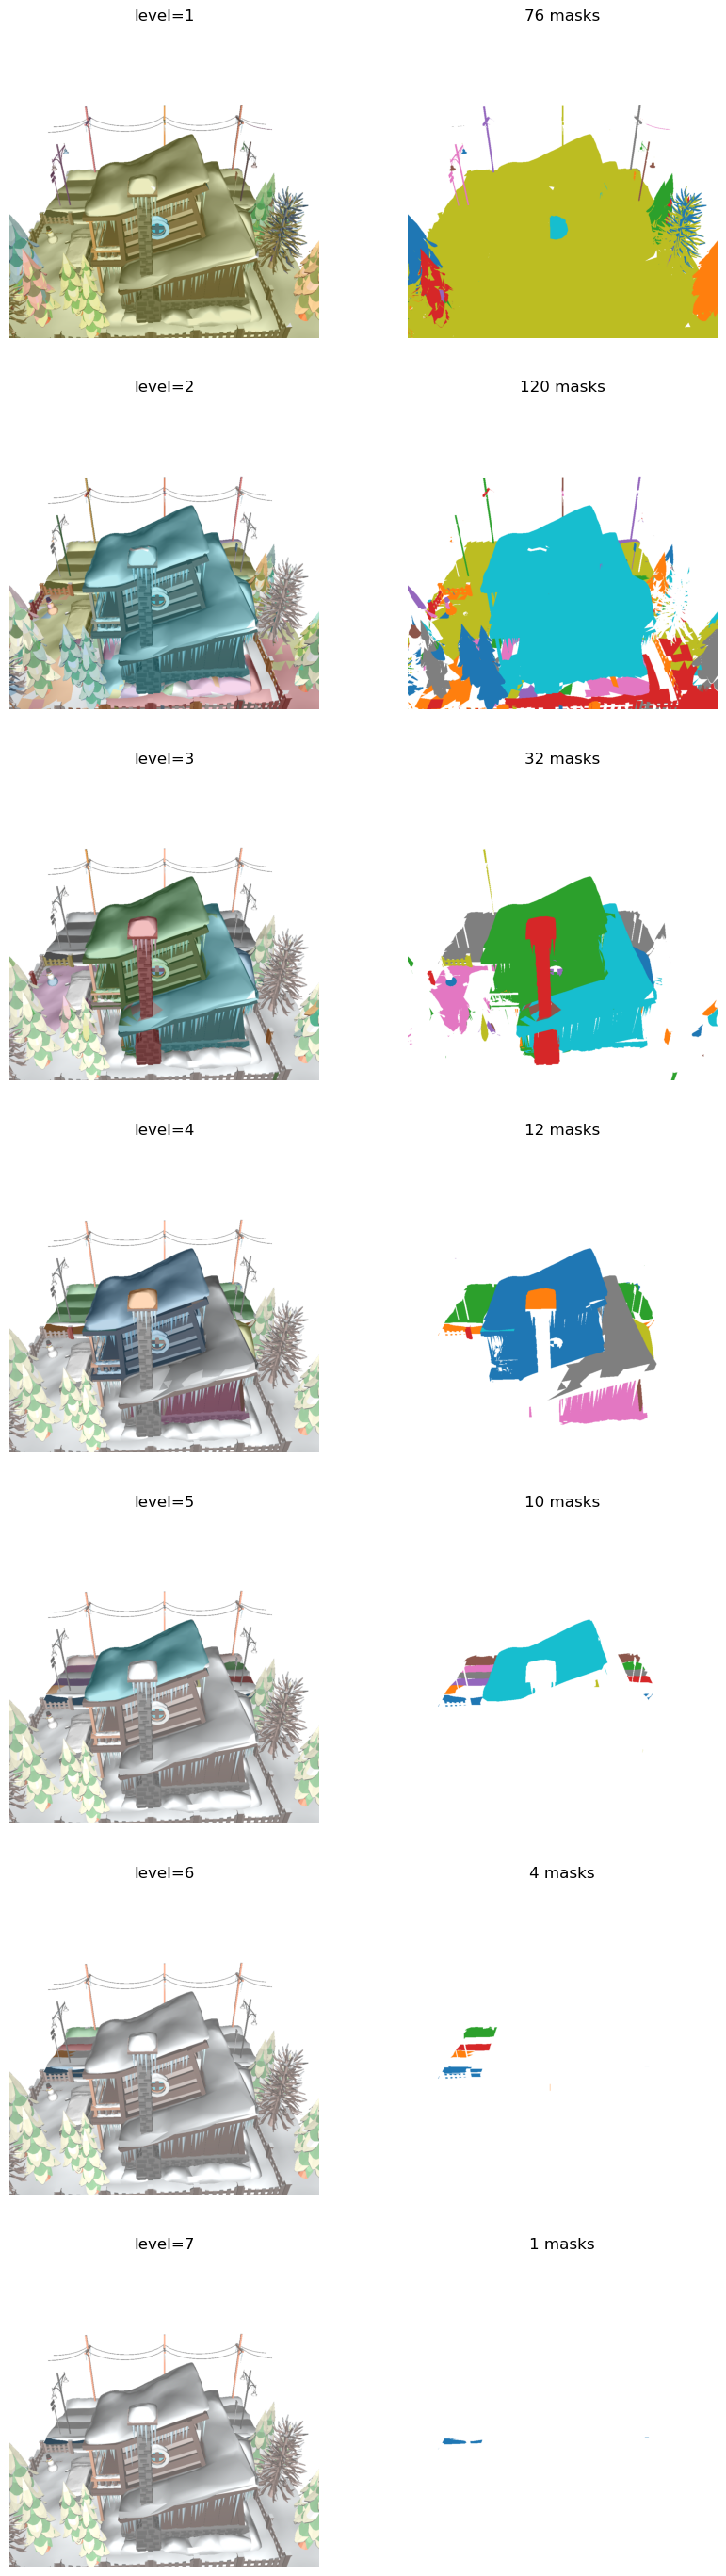

In [12]:
show_index = 8
ts.show_all_levels(images[show_index, :, :, :3], tree3d, tri_ids[show_index])
tree3d.print_tree()

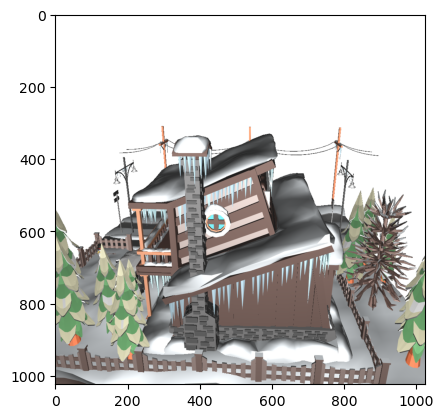

In [54]:
def save_results(index, alpha=0.5):
    image = images[index]
    utils.save_image(cache_dir.joinpath(f'view_{index}.png'), image)
    plt.imshow(image.cpu().numpy())
    plt.show()
    return
  
    tree2d = get_2d_tree_from_3d(tree3d, tri_ids[index].to(device))    
    image = image.cpu().numpy()
    for level, nodes in enumerate( tree2d.get_levels()):
        if level == 0:
            continue
        image_l = image.copy()
        colored_mask = ts.get_colored_masks(tree2d.masks[nodes-1])
        image_l = cv2.addWeighted(image_l, alpha, colored_mask, 1-alpha, 0)
        for x in nodes:
            p = tree2d.parent[x].item() - 1
            x = x.item() - 1
            image_l = ts.image_add_mask_boundary(image_l, tree2d.masks[x], color=(0, 0, 0), kernel_size=5)
            # image_l = ts.image_add_mask_boundary(image_l, tree2d.masks[p],color=(0, 0, 0),  kernel_size=9)
        utils.save_image(cache_dir.joinpath(f'view_{index}_l{level}.png'), image_l)
        plt.imshow(image_l)
        plt.show()


# for i in range(22):
save_results(22)